**UTILITY FUNCTIONS AND LIBRARIES***

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

***DATASET LOADING***

In [98]:
df = pd.read_csv("../dataset/layoffs_data.csv")

***DATASET PRELIMINARY ANALYSIS***

In [99]:
df

,Company,Location_HQ,Industry,Percentage,Date,Source,Funds_Raised,Stage,Date_Added,Country,Laid_Off_Count,List_of_Employees_Laid_Off
0,Fisker,Los Angeles,Transportation,0.15,2024-02-29,https://techcrunch.com/2024/02/29/fisker-layof...,1700.0,Post-IPO,2024-02-29 23:35:20,United States,NaN,Unknown
1,Electronic Arts,SF Bay Area,Consumer,0.05,2024-02-28,https://www.cnbc.com/2024/02/28/ea-layoffs-com...,2.0,Post-IPO,2024-02-29 00:45:00,United States,670.0,Unknown
2,Vacasa,Portland,Travel,0.05,2024-02-28,https://www.oregonlive.com/business/2024/02/po...,834.0,Post-IPO,2024-02-29 17:22:37,United States,320.0,Unknown
3,Treasury Prime,SF Bay Area,Finance,0.40,2024-02-28,https://www.bankingdive.com/news/treasury-prim...,71.0,Series C,2024-02-29 00:48:03,United States,40.0,Unknown
4,Motional,Boston,Transportation,0.05,2024-02-28,https://techcrunch.com/2024/02/28/hyundai-back...,NaN,Unknown,2024-02-28 18:50:58,United States,NaN,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
3480,Service,Los Angeles,Travel,1.00,2020-03-16,https://techcrunch.com/2020/03/16/travel-savin...,5.1,Seed,2020-08-31 15:17:26,United States,NaN,Unknown
3481,HopSkipDrive,Los Angeles,Transportation,0.10,2020-03-13,https://layoffs.fyi/2020/04/02/hopskipdrive-la...,45.0,Unknown,2020-04-03 04:47:03,United States,8.0,Unknown
3482,Panda Squad,SF Bay Area,Consumer,0.75,2020-03-13,https://twitter.com/danielsinger/status/123854...,1.0,Seed,2020-04-17 00:12:49,United States,6.0,Unknown
3483,Tamara Mellon,Los Angeles,Retail,0.40,2020-03-12,https://layoffs.fyi/list/tamara-mellon/,90.0,Series C,2020-03-31 16:04:23,United States,20.0,Unknown


In [100]:
df.shape

(3485, 12)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3485 entries, 0 to 3484
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Company                     3485 non-null   object 
 1   Location_HQ                 3485 non-null   object 
 2   Industry                    3485 non-null   object 
 3   Percentage                  2245 non-null   float64
 4   Date                        3485 non-null   object 
 5   Source                      3485 non-null   object 
 6   Funds_Raised                3115 non-null   float64
 7   Stage                       3485 non-null   object 
 8   Date_Added                  3485 non-null   object 
 9   Country                     3485 non-null   object 
 10  Laid_Off_Count              2290 non-null   float64
 11  List_of_Employees_Laid_Off  3484 non-null   object 
dtypes: float64(3), object(9)
memory usage: 326.8+ KB


Therefore we have null/unknown values in 'Laid_Off_count', 'Percentage', 'Funds_Raised', 'List_of_Employees_Laid_Off'

'List_of_Employees_Laid_Off' can be removed as it isnt signficant due to all major values being 'Unknown' and other files being links to spreadsheets. The race, position and other characteristics should have been taken into account but wasnt possible here.

'Source' can be dropped as well due to links.

In [102]:
df['List_of_Employees_Laid_Off'].value_counts()
%pip install ipywidgets

In [103]:
df_analysis = ProfileReport(df)
df_analysis

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


In [104]:
def drop_cols(df,cols):
    for i in cols:
        del df[i]
    return df

In [105]:
df = drop_cols(df, ['Source','List_of_Employees_Laid_Off', 'Date_Added'])

In [106]:
df.isna().any()

Company           False
Location_HQ       False
Industry          False
Percentage         True
Date              False
Funds_Raised       True
Stage             False
Country           False
Laid_Off_Count     True
dtype: bool

In [107]:
df.isin(['Unknown']).any()

Company           False
Location_HQ        True
Industry           True
Percentage        False
Date              False
Funds_Raised      False
Stage              True
Country           False
Laid_Off_Count    False
dtype: bool

'Laid_Off_Count', 'Percentage', 'Funds_Raised' have missing values

'Industry', 'Stage',  have Unknown Values

9 features

Categorical : 'Company' , 'Location' , 'Industry', 'Date', 'Stage', 'Country'

Numeric : 'Laid_Off_Count', 'Percentage', 'Funds_Raised' 

In [116]:
cat_ex = ['Company', 'Location_HQ', 'Country']
round_ex = ['Layoffs', 'Funds_Raised', 'Industry', 'Stage']
cat_fill_ex = ['Industry', 'Stage']
num_fill_ex = [ 'Percentage','Layoffs','Funds_Raised']
num_cols = ['Layoffs', 'Percentage', 'Funds_Raised']
print(df.columns)

Index(['Unnamed: 0', 'Company', 'Location_HQ', 'Industry', 'Percentage',
       'Funds_Raised', 'Stage', 'Country', 'Layoffs', 'year_month', 'quarter',
       'year', 'Date_month', 'Date_day'],
      dtype='object')


In [117]:
def cat2num(df,cols):
    oe = OrdinalEncoder()
    for i in cols:
        df[i] = oe.fit_transform(df[[i]])
        df[i] = df[i].astype('int')
    return df

In [118]:
# def impute(df,cols):
#     my_imputer = SimpleImputer()
#     for i in cols:
#         df[i] = my_imputer.fit_transform(df[[i]])
#     return df

In [119]:
def round2(df,cols):
    for i in cols:
        df[i] = df[i].astype(int)
    return df

In [120]:
def date2convert(df,col):
    df[col] = pd.to_datetime(df[col])
    df['Date_month'] = df[col].dt.month
    df['Date_day'] = df[col].dt.day
    del df[col]
    return df

In [121]:
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier


def cat2fill(df,cols):
    df[cols] = df[cols].apply(lambda series: pd.Series(LabelEncoder().fit_transform(series[series.notnull()].index)))
    imp_cat = IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent')
    df[cols] = imp_cat.fit_transform(df[cols])
    return df

In [122]:
def num2fill(df,cols):
    imp_num = IterativeImputer(estimator=RandomForestRegressor(),
                               initial_strategy='mean',
                               max_iter=10, random_state=0)
    df[cols] = imp_num.fit_transform(df[cols])
    return df

In [123]:
df = pd.read_csv("../dataset/cleaned.csv")
# df = drop_cols(df, ['Source','List_of_Employees_Laid_Off', 'Date_Added'])
df = df.replace('Unknown', np.nan)
df = num2fill(df,num_fill_ex)
df = cat2num(df,cat_ex)
df = date2convert(df, 'Date')
df = cat2fill(df,cat_fill_ex)
df = round2(df, round_ex)
df

c:\Users\670310840\Downloads\Documents\GitHub\Layoffs\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Unnamed: 0,Company,Location_HQ,Industry,Percentage,Funds_Raised,Stage,Country,Layoffs,year_month,quarter,year,Date_month,Date_day
0,2,871,89,0,0.05,834,0,37,320,02/2024,2024Q1,2024,2,28
1,3,832,94,1,0.40,71,1,37,40,02/2024,2024Q1,2024,2,28
2,6,132,4,2,0.30,313,2,37,350,02/2024,2024Q1,2024,2,27
3,16,294,110,3,0.17,30,3,1,60,02/2024,2024Q1,2024,2,21
4,20,786,62,4,0.25,5,4,36,55,02/2024,2024Q1,2024,2,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140,3472,667,24,1140,0.50,17,999,37,50,03/2020,2020Q1,2020,3,19
1141,3477,307,14,1141,0.20,4,999,37,4,03/2020,2020Q1,2020,3,18
1142,3478,410,32,1142,0.22,79,999,37,130,03/2020,2020Q1,2020,3,16
1143,3481,379,63,1143,0.10,45,999,37,8,03/2020,2020Q1,2020,3,13


In [124]:
df.isnull().sum()

Unnamed: 0      0
Company         0
Location_HQ     0
Industry        0
Percentage      0
Funds_Raised    0
Stage           0
Country         0
Layoffs         0
year_month      0
quarter         0
year            0
Date_month      0
Date_day        0
dtype: int64

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1145 non-null   int64  
 1   Company       1145 non-null   int32  
 2   Location_HQ   1145 non-null   int32  
 3   Industry      1145 non-null   int32  
 4   Percentage    1145 non-null   float64
 5   Funds_Raised  1145 non-null   int32  
 6   Stage         1145 non-null   int32  
 7   Country       1145 non-null   int32  
 8   Layoffs       1145 non-null   int32  
 9   year_month    1145 non-null   object 
 10  quarter       1145 non-null   object 
 11  year          1145 non-null   int64  
 12  Date_month    1145 non-null   int32  
 13  Date_day      1145 non-null   int32  
dtypes: float64(1), int32(9), int64(2), object(2)
memory usage: 85.1+ KB


***APPLYING ML MODELS & HYPERPARAMETER TUNING***

In [129]:
from sklearn.preprocessing import MinMaxScaler

print(df.columns)

df = df.drop(columns=['year_month', 'quarter', 'year'])

scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df = pd.DataFrame(df)
y = df['Industry'].values
X = df.drop('Industry',axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

Index(['Unnamed: 0', 'Company', 'Location_HQ', 'Industry', 'Percentage',
       'Funds_Raised', 'Stage', 'Country', 'Layoffs', 'year_month', 'quarter',
       'year', 'Date_month', 'Date_day'],
      dtype='object')


In [130]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=8)             
rfe = rfe.fit(X_train, y_train)
list(zip(df.columns,rfe.support_,rfe.ranking_))


[('Unnamed: 0', True, 1),
 ('Company', False, 3),
 ('Location_HQ', False, 2),
 ('Industry', True, 1),
 ('Percentage', True, 1),
 ('Funds_Raised', True, 1),
 ('Stage', True, 1),
 ('Country', True, 1),
 ('Layoffs', True, 1),
 ('Date_month', True, 1)]

In [131]:
y_pred = rfe.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)

0.995371393718791


In [132]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores

array([0.99562521, 0.99598947, 0.9939623 , 0.99557149, 0.99524981])

In [133]:
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-508.61809257, -481.83352476, -519.39770821, -572.42801144,
       -556.77553572])

In [134]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
hyper_params = [{'n_features_to_select': list(range(1, 10))}]
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)   
model_cv.fit(X_train, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9]}],
             return_train_score=True, scoring='r2', verbose=1)

In [135]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.007002,0.001674,0.000600,0.000490,1,{'n_features_to_select': 1},0.020227,-0.000925,0.002881,0.044550,...,0.013734,0.017110,9,0.030132,0.035853,0.029767,0.025358,0.033615,0.030945,0.003591
1,0.005602,0.000490,0.000000,0.000000,2,{'n_features_to_select': 2},0.045250,0.013642,0.030468,0.073556,...,0.037917,0.020470,8,0.043713,0.051883,0.044696,0.038081,0.049351,0.045545,0.004784
2,0.005039,0.000074,0.000800,0.000400,3,{'n_features_to_select': 3},0.051847,0.012627,0.039412,0.078957,...,0.042652,0.022200,7,0.046988,0.056855,0.046482,0.041336,0.053363,0.049005,0.005475
3,0.004201,0.000399,0.000401,0.000491,4,{'n_features_to_select': 4},0.994816,0.995438,0.043345,0.085949,...,0.622855,0.455974,6,0.994350,0.994197,0.050543,0.044569,0.994374,0.615607,0.463815
4,0.009900,0.012073,0.000800,0.000400,5,{'n_features_to_select': 5},0.994816,0.995439,0.992313,0.994621,...,0.994396,0.001078,5,0.994350,0.994197,0.994969,0.994402,0.994400,0.994464,0.000263
5,0.005003,0.000633,0.000999,0.000632,6,{'n_features_to_select': 6},0.994780,0.995494,0.992358,0.994665,...,0.994520,0.001125,4,0.994402,0.994229,0.995005,0.994436,0.995424,0.994699,0.000447
6,0.008601,0.004760,0.001401,0.000802,7,{'n_features_to_select': 7},0.995697,0.996007,0.993983,0.995587,...,0.995309,0.000704,1,0.995331,0.995247,0.995739,0.995362,0.995432,0.995422,0.000169
7,0.003405,0.000800,0.000600,0.000490,8,{'n_features_to_select': 8},0.995673,0.995999,0.993959,0.995571,...,0.995294,0.000707,2,0.995337,0.995250,0.995740,0.995366,0.995432,0.995425,0.000168
8,0.002803,0.000751,0.000909,0.000807,9,{'n_features_to_select': 9},0.995674,0.996002,0.993963,0.995575,...,0.995293,0.000707,3,0.995337,0.995251,0.995741,0.995367,0.995438,0.995427,0.000168


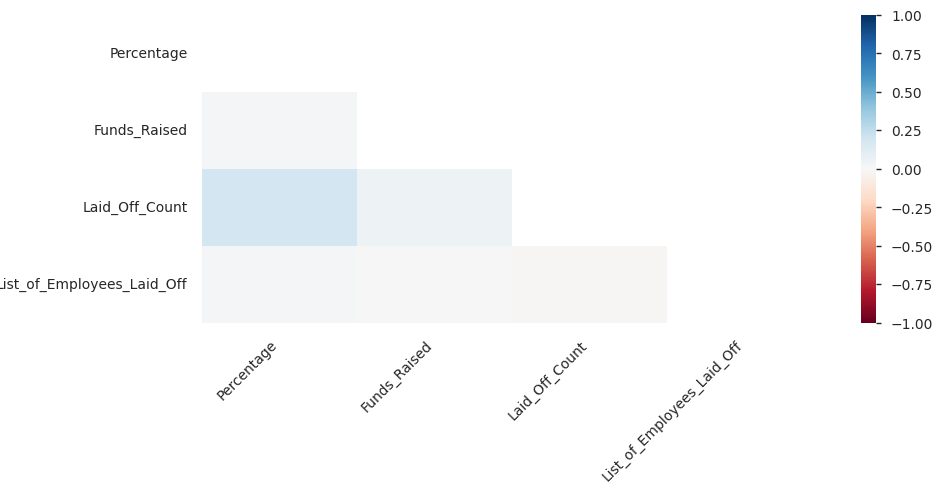

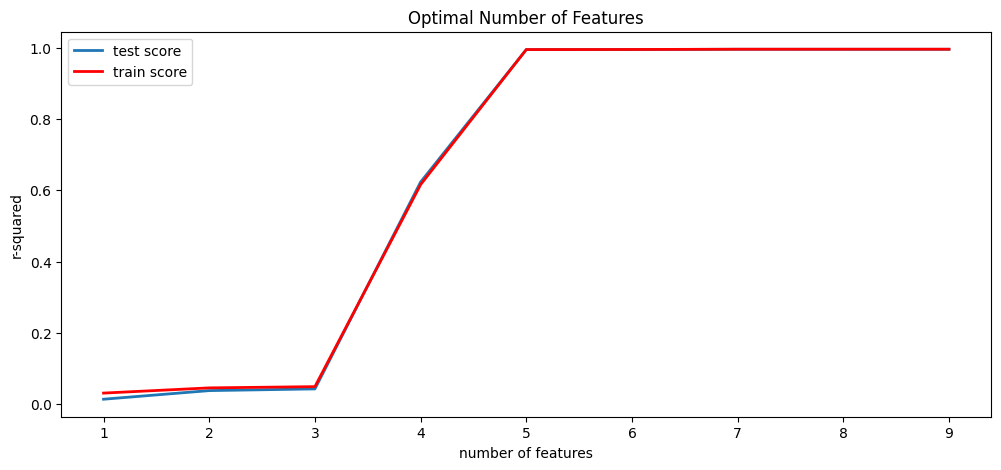

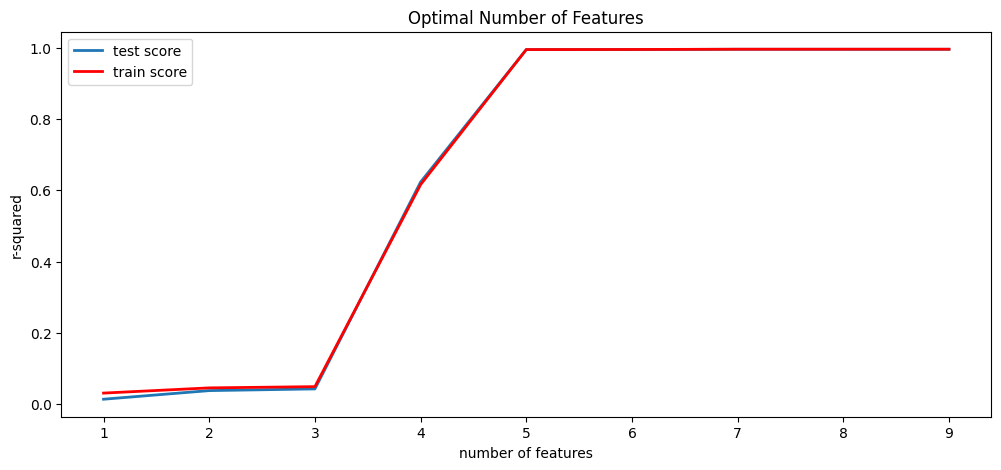

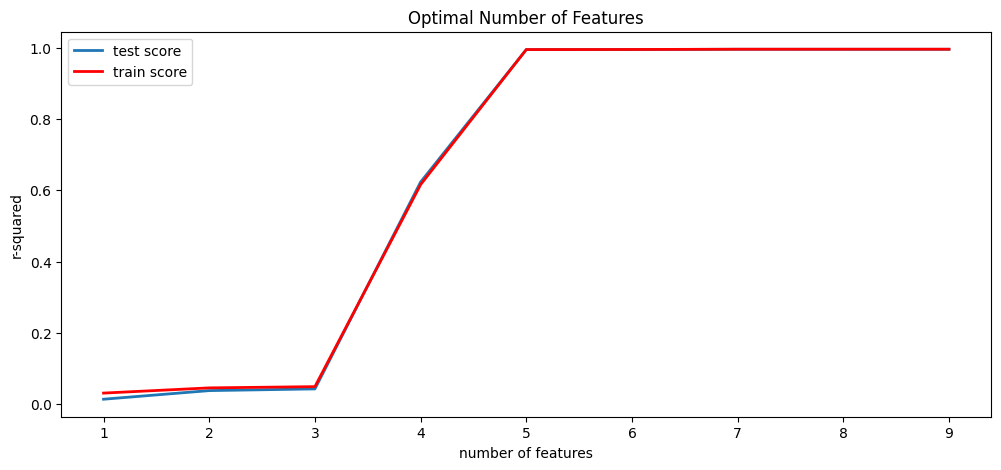

In [138]:
%matplotlib inline

plt.figure(figsize=(12,5))
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"], linewidth=2)
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"], color='red', linewidth=2)
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

plt.show()